___
# Loading the data and libraries
___

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings

while any(marker in os.getcwd() for marker in ['workspace_p3']):
    os.chdir("..")

sys.path.append('classes_and_functions_p3')

current_directory = os.getcwd()
current_directory

'c:\\Users\\barto\\Desktop\\Repos\\MachineLearning\\Project3'

In [14]:
import itertools

# Importing external packages
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    VotingClassifier,
    AdaBoostClassifier,
    StackingClassifier,
    RandomForestClassifier
)
import xgboost as xgb

# Importing custom-made functions and classes
# from classes_and_functions_p3.custom_functions_classes_p3 import (

# )

In [7]:
raw_data = pd.read_csv('attachments_p3/Data_set_task_3.csv')
raw_data

,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,0,147.32.80.9,147.32.84.165,4,2,134,558,1.312967e+09,1.312967e+09,...,207900.070205,0.885171,0.205123,0.417904,NaN,4248.583372,4544.559854,0.564213,0.003325,neris
1,1,1,147.32.84.255,147.32.84.165,38,0,2476,0,1.312967e+09,1.312967e+09,...,5314.872532,0.038851,0.241710,0.223803,-1.333903,3.640725,0.786195,-0.830029,0.046606,clear
2,2,2,147.32.84.255,147.32.84.165,6,0,1160,0,1.312967e+09,1.312967e+09,...,-271216.457937,0.010243,0.393857,0.271931,NaN,214.629001,1171.605316,-0.489713,0.011965,clear
3,3,3,147.32.84.165.,60.190.222.139,4,0,249,0,1.312967e+09,1.312967e+09,...,-1060.499747,0.006667,0.407122,0.273574,-0.362061,1.505125,2.539462,-0.400313,0.010620,clear
4,4,4,60.190.222.139.,147.32.84.165,10,0,138,0,1.312967e+09,1.312967e+09,...,-4837.676869,0.187056,0.482592,0.285750,-0.098411,1.314013,2.857491,0.565604,0.021624,clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176635,11618,11618,64.142.97.114.,147.32.84.165,2,0,0,0,1.313558e+09,1.313558e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176636,11619,11619,147.32.84.165.,95.130.170.231,1,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176637,11620,11620,95.130.170.231.,147.32.84.165,2,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176638,11621,11621,147.32.84.165.,199.59.164.114,2,0,0,0,1.313565e+09,1.313565e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear


---
# ***EDA***
---

In [9]:
raw_data.dtypes

Unnamed: 0.1            int64
Unnamed: 0              int64
DST_IP                 object
SRC_IP                 object
PACKETS                 int64
                       ...   
SPECTRAL_CREST        float64
SPECTRAL_FLUX         float64
SPECTRAL_BANDWIDTH    float64
PERIODICITY_SCDF      float64
LABEL                  object
Length: 85, dtype: object

In [18]:
raw_data.dtypes[raw_data.dtypes == object]

DST_IP    object
SRC_IP    object
LABEL     object
dtype: object

In [21]:
len(raw_data['DST_IP'].unique())

36781

In [10]:
nulls_percentage = raw_data.isnull().mean() * 100
print('Percentage of nulls in each feature')
nulls_percentage

Percentage of nulls in each feature


Unnamed: 0.1           0.000000
Unnamed: 0             0.000000
DST_IP                 0.000000
SRC_IP                 0.000000
PACKETS                0.000000
                        ...    
SPECTRAL_CREST        75.588202
SPECTRAL_FLUX         75.588202
SPECTRAL_BANDWIDTH     0.000000
PERIODICITY_SCDF      75.588202
LABEL                  0.000000
Length: 85, dtype: float64

In [11]:
nulls_percentage[nulls_percentage>50]

MIN_POWER            75.588202
MAX_POWER            75.588202
MIN_POWER_FREQ       75.588202
MAX_POWER_FREQ       75.588202
POWER_MEAN           75.588202
POWER_STD            75.588202
SPECTRAL_ENERGY      75.588202
SPECTRAL_ENTROPY     84.326313
SPECTRAL_KURTOSIS    75.588202
SPECTRAL_SKEWNESS    75.588202
SPECTRAL_CENTROID    77.732111
SPECTRAL_SPREAD      79.586164
SPECTRAL_SLOPE       85.224185
SPECTRAL_CREST       75.588202
SPECTRAL_FLUX        75.588202
PERIODICITY_SCDF     75.588202
dtype: float64

Maybe we should consider getting rid of these columns

---
# ***Raw Classifier***
---

In [22]:
label_encoder = LabelEncoder()
raw_data['DST_IP'] = label_encoder.fit_transform(raw_data['DST_IP'])
raw_data['SRC_IP'] = label_encoder.fit_transform(raw_data['SRC_IP'])


Accuracy: 0.9998160099637681
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    132472
           1       1.00      0.86      0.93        22
           2       1.00      1.00      1.00      3502
           3       1.00      1.00      1.00      5045
           4       1.00      1.00      1.00       227
           5       0.92      0.75      0.82        44

    accuracy                           1.00    141312
   macro avg       0.98      0.93      0.96    141312
weighted avg       1.00      1.00      1.00    141312



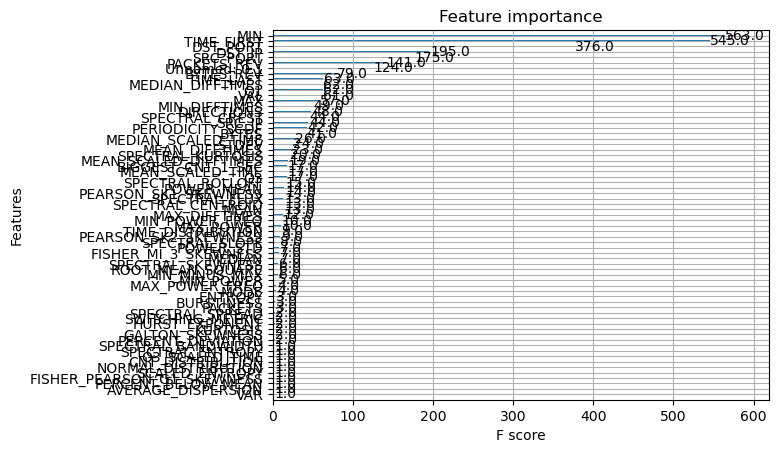

In [26]:
X = raw_data.drop(columns=["LABEL"])  # Features
y = raw_data["LABEL"]  # Target

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.8, random_state=42)

# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    enable_categorical = True
)

# Train the classifier
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Feature importance
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_clf)
plt.show()